# Imports

In [27]:
import os, sys, random, time, copy, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import lightning as L

from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

from torchmetrics.aggregation import RunningMean

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

from torchinfo import summary

from PIL import Image

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
os.chdir("applied-ml-assignment-5/src")

# Setting up the data

In [3]:
CHICKEN_IMAGES_PATH = "../data/chicken/data"
DUCK_IMAGES_PATH = "../data/duck/data"

In [4]:
def create_annotations_file(paths: list[str]):
    # training dataset
    train = pd.DataFrame(columns=["path", "class"])
    for path in paths:
        full_path = os.path.join(path, "train")
        image_names = [f"{path}/train/{_}" for _ in os.listdir(full_path)[:100]]
        label = path.split("/")[2]
        temp = pd.DataFrame({"path": image_names, "class": label})
        train = pd.concat([train, temp])

    # validation dataset
    val = pd.DataFrame(columns=["path", "class"])
    for path in paths:
        full_path = os.path.join(path, "val")
        image_names = [f"{path}/val/{_}" for _ in os.listdir(full_path)[:50]]
        label = path.split("/")[2]
        temp = pd.DataFrame({"path": image_names, "class": label})
        val = pd.concat([val, temp])

    # test dataset
    test = pd.DataFrame(columns=["path", "class"])
    for path in paths:
        full_path = os.path.join(path, "test")
        image_names = [f"{path}/test/{_}" for _ in os.listdir(full_path)[:100]]
        label = path.split("/")[2]
        temp = pd.DataFrame({"path": image_names, "class": label})
        test = pd.concat([test, temp])

    train = train.reset_index(drop=True)
    val = val.reset_index(drop=True)
    test = test.reset_index(drop=True)

    return train, val, test


train, val, test = create_annotations_file([CHICKEN_IMAGES_PATH, DUCK_IMAGES_PATH])

Next we will create the dataset

In [5]:
class ChickenOrDuck(Dataset):

    def __init__(
        self, annotations_file, transforms=transforms.Compose([transforms.ToTensor()])
    ):
        super().__init__()
        self.annotations_file = annotations_file
        self.transforms = transforms

    def __getitem__(self, index):
        image_path = self.annotations_file.loc[index, "path"]
        image_class = self.annotations_file.loc[index, "class"]
        image_label = 1 if image_class == "chicken" else 0

        image = Image.open(image_path).convert("RGB")
        image = image.resize((128, 128))
        image = self.transforms(image)

        return image, image_label

    def __len__(self):
        return len(self.annotations_file)

In [6]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
image_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    ),
}

train_dataset = ChickenOrDuck(train, image_transforms["train"])
val_dataset = ChickenOrDuck(val, image_transforms["val"])
test_dataset = ChickenOrDuck(test, image_transforms["val"])

## Training Hyperparameters

In [7]:
BATCH_SIZE = 20
LR = 2e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
train_running_metric = RunningMean(window=5)
val_running_metric = RunningMean(window=5)

training_loss = []
training_acc = []
val_loss = []
val_acc = []


class ImagenetTransferLearning(L.LightningModule):
    def __init__(self):
        super().__init__()

        backbone = resnet18(ResNet18_Weights.IMAGENET1K_V1)
        layers = list(backbone.children())
        num_in = backbone.fc.in_features
        num_target_classes = 2
        layers[-1] = nn.Sequential(
            *[nn.Flatten(), nn.Linear(num_in, num_target_classes)]
        )
        # self.full_model = nn.Sequential(*layers)
        self.classifier = layers[-1]
        self.feature_extractor = nn.Sequential(*layers[:-1])

    def forward(self, x):
        with torch.no_grad():
            representations = self.feature_extractor(x)
        x = self.classifier(representations)
        return torch.argmax(x, dim=-1)

    def training_step(self, batch, batch_idx, datalaoder_idx=None):
        x, y = batch
        with torch.no_grad():
            representations = self.feature_extractor(x)
        x = self.classifier(representations)
        loss = F.cross_entropy(x, y)
        pred = torch.argmax(x, dim=1).cpu().numpy()
        true = y.cpu().numpy()
        _ = train_running_metric(accuracy_score(true, pred) * 100)
        accuracy = train_running_metric.compute()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train acc", accuracy, prog_bar=True)
        training_loss.append(loss.cpu().item())
        training_acc.append(accuracy.cpu().item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(
            params=filter(lambda p: p.requires_grad, self.classifier.parameters()),
            lr=LR,
        )
        return optimizer

    def validation_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        x = self.feature_extractor(x)
        x = self.classifier(x)
        loss = F.cross_entropy(x, y)
        pred = torch.argmax(x, dim=1).cpu().numpy()
        true = y.cpu().numpy()
        _ = val_running_metric(accuracy_score(true, pred) * 100)
        accuracy = val_running_metric.compute()
        val_loss.append(loss.cpu().item())
        val_acc.append(accuracy.cpu().item())
        self.log("validation", loss, prog_bar=True)
        self.log("validation acc", accuracy, prog_bar=True)

In [15]:
model = ImagenetTransferLearning()
trainer = L.Trainer(
    max_epochs=25,
)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type       | Params
-------------------------------------------------
0 | classifier        | Sequential | 1.0 K 
1 | feature_extractor | Sequential | 11.2 M
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


After training we see that we get training accuracy of 94% and validation accuracy opf 86% 

# Classification results

In [32]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
for x, y in test_dataloader:
    pred = model(x)
    print(classification_report(y_true=y, y_pred=pred, target_names=["duck", "chicken"]))

              precision    recall  f1-score   support

        duck       0.92      0.92      0.92       100
     chicken       0.92      0.92      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



## Visualising the results

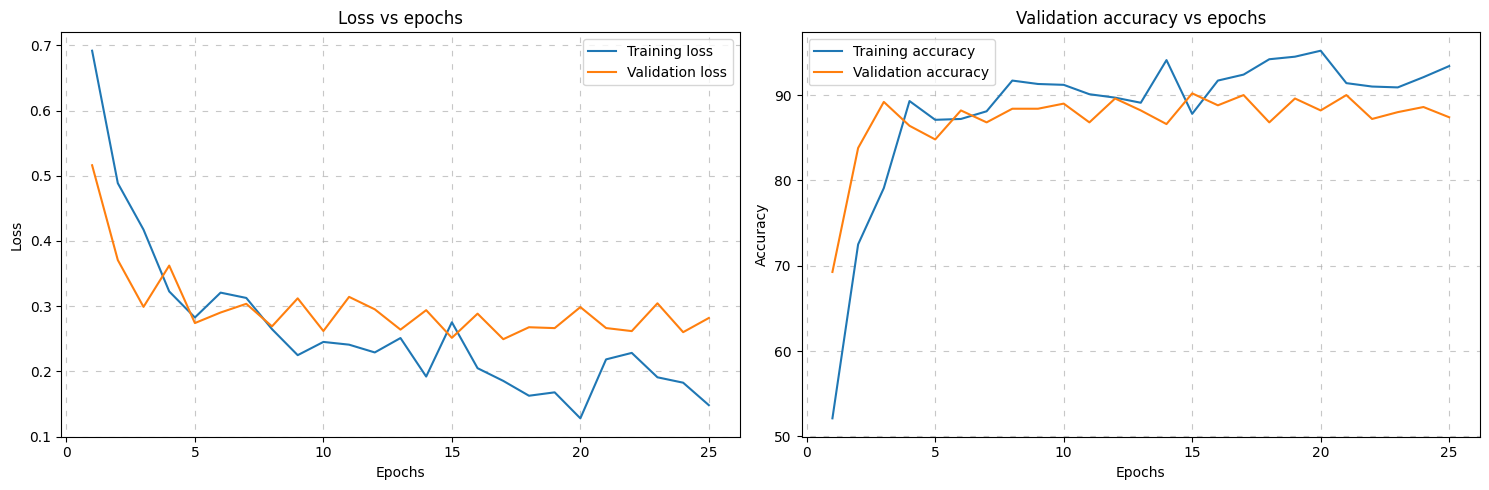

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.lineplot(
    x=np.arange(1, 26, 1), 
    y=np.mean(
        np.array(training_loss).reshape(-1, 10), 
        axis=1
    ), 
    label="Training loss", 
    ax=axs[0]
)
sns.lineplot(
    x=np.arange(1, 26, 1), 
    y=np.mean(
        np.array(val_loss[2:]).reshape(-1, 5), 
        axis=1
    ), 
    label="Validation loss", 
    ax=axs[0]
)
axs[0].set_title("Loss vs epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

sns.lineplot(
    x=np.arange(1, 26, 1), 
    y=np.mean(
        np.array(training_acc).reshape(-1, 10), 
        axis=1
    ), 
    label="Training accuracy", 
    ax=axs[1]
)
sns.lineplot(
    x=np.arange(1, 26, 1), 
    y=np.mean(
        np.array(val_acc[2:]).reshape(-1, 5), 
        axis=1
    ), 
    label="Validation accuracy", 
    ax=axs[1]
)
axs[1].set_title("Validation accuracy vs epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

plt.legend()
plt.tight_layout()
axs[0].grid(visible=True, which="major", axis="both", ls=(5, (5, 7)), alpha=0.7)
axs[1].grid(visible=True, which="major", axis="both", ls=(5, (5, 7)), alpha=0.7)
plt.show()